In [414]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as smf
import numpy as np
from src.helpers import *
pd.options.mode.chained_assignment = None  

In [415]:
ethn_div = pd.read_csv('generated/ethnicity_diversity.csv', sep=',')
gen_div = pd.read_csv('generated/gender_diversity.csv', sep=',')
movie_charac = pd.read_csv('generated/movie_characters.csv', sep=',')

## Functions

### Last cleaning of the Dataset

In [416]:

def filtering(df, performance_param):
    ''' 
    Filter the dataframe according 
    to the performance parameter

    Parameters:
    -df: A dataframe
    -performance_param: A string
    
    Return: 
    -A dataframe
    '''
    df_copy = df.copy()
    if (performance_param == 'box_office'):
        df_copy.dropna(subset=['movie_box_office_revenue'],inplace=True)
        return df_copy

    elif (performance_param == 'rating'):
        vote_threshold = 100
        df_copy.dropna(subset=['rating_average','movie_box_office_revenue'],inplace=True)
        df_bis = df_copy[df_copy['rating_count'] > vote_threshold]
        return df_bis

    else:
        print("Invalid parameters")
        
    

def year_release_split(df, number_parts):
    ''' 
    Split the dataframe in number_parts 
    according to the year of release

    Parameters:
    -df: A dataframe
    -number_parts: An integer
    
    Return: 
    -df: A dictionary of dataframes 
    -cutoff: A list of the cutoff years
    '''
    total_size = df.shape[0]
    share = int(total_size/(number_parts))
    cumulative_data = df['movie_release_year'].value_counts().sort_index().cumsum()
    cutoff = []
    for i in range(number_parts):
        relevant_data = cumulative_data[cumulative_data > (i)*share] 
        if not relevant_data.empty:
            cutoff.append(relevant_data.index[0])

    period_dataframes = {}
    for i in range(len(cutoff)):
        if i < len(cutoff)-1:
            period_df = df[
                (df['movie_release_year'] > cutoff[i]) &
                (df['movie_release_year'] <= cutoff[i+1])
            ]
        if i == len(cutoff)-1:
            period_df = df[
                (df['movie_release_year'] > cutoff[i])
            ]

        period_dataframes[f'df_period{i+1}'] = period_df
    return period_dataframes,cutoff  

### Regression

In [417]:
def common_movie_gender(str1, str2):  
    '''
    Check if two movies have at least one common genre

    Parameters:
    -str1: A string
    -str2: A string

    Return:
    -common_elements: A boolean
    '''
    # Convert string representation of lists to actual lists
    list1 = [genre.strip() for genre in str1.strip("[]").split(",")]
    list2 = [genre.strip() for genre in str2.strip("[]").split(",")]

    set1 = set(list1)
    set2 = set(list2)
    common_elements = set1.intersection(set2)
    return common_elements

    
def min_max_scaling(df, column_name):
    '''
    Scale the values of a column between 0 and 1

    Parameters:
    -df: A dataframe
    -column_name: A list of string

    Return:
    -df: A dataframe 
    '''
    for col in column_name:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

def binarize_diversity(df, column_name):
    '''
    Binarize the diversity column using the median value

    Parameters:
    -df: A dataframe
    -column_name: A string

    Return: 
    -df: A dataframe 
    '''
    median_value = df[column_name].median()
    df['treat'] = np.where(df[column_name] > median_value, 1, 0)
    return df

def add_propensity_score(df,formula_propensity_score,diversity_name,column_name):
    '''
    Add a column with the propensity score to the dataframe

    Parameters:
    -df: A dataframe
    -formula_propensity_score: A string
    -diversity_name: A string
    -column_name: A string
    
    Return: 
    -df: A dataframe 
    '''
    df = binarize_diversity(df,diversity_name)
    df = min_max_scaling(df,column_name)
    mod = smf.logit(formula= formula_propensity_score, data=df)
    res = mod.fit(disp=False)
    df['Propensity_score'] = res.predict()
    return df

def get_similarity(propensity_score1, propensity_score2):
    '''
    Calculate similarity for instances with given propensity scores

    Parameters:
    -propensity_score1: A float
    -propensity_score2: A float
    
    Return: A float
    '''
    return 1-np.abs(propensity_score1-propensity_score2)

def compute_balance_df(df): 
    '''
    Compute a balanced dataframe using the propensity score

    Parameters:
    -df: A dataframe

    Return: 
    -df: A dataframe
    '''
    # Separate the treatment and control groups
    treatment_df = df[df['treat'] == 1]
    control_df = df[df['treat'] == 0]

    # Create an empty graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():
            # Check if the two instances have the same number of languages and at least one common genre
            if (control_row['movie_languages_count'] == treatment_row['movie_languages_count']) \
                and common_movie_gender(control_row['movie_genres'], treatment_row['movie_genres']):
                # Calculate the similarity 
                similarity = get_similarity(control_row['Propensity_score'],
                                            treatment_row['Propensity_score'])

                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)

    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    balanced_df = df.loc[matched]
    return balanced_df

def regression(df,formula,formula_propensity_score,diversity_name,column_name):
    '''
    Perform an ols regression on a dataframe according to the formula

    Parameters:
    -df: A dataframe
    -formula: A string
    -formula_propensity_score: A string
    -diversity_name: A string
    -column_name: A lsit of string

    Return: 
    -balanced_df: A dataframe 
    -mod: A model
    '''
    df = add_propensity_score(df, formula_propensity_score, diversity_name, column_name)
    balanced_df = compute_balance_df(df)
    mod = smf.ols(formula=formula, data=balanced_df)
    return balanced_df,mod


def compute_all_regressions(period_df,formula,formula_propensity_score,diversity_name,columns):
    '''
    Perform the regression for each period and store the results in a list

    Parameters:
    -period_df: A dataframe
    -formula: A string
    -formula_propensity_score: A string
    -diversity_name: A string
    -columns: A lsit of string


    Return: 
    -balanced_dfs: A list of tuples containing the balanced dataframe
    -mods: A list of tuples containing the model
    '''
    # Create an empty list to store the results
    results = []

    # Iterate over periods
    for period_num in range(1, 11):
        period_key = f'df_period{period_num}'
        
        # Perform regression for each period
        balanced_df, mod = regression(
            period_df[period_key],
            formula=formula,
            formula_propensity_score=formula_propensity_score,
            diversity_name=diversity_name,
            column_name=columns
        )
        
        # Store the results in a tuple and append to the list
        result = (balanced_df, mod)
        results.append(result)

    # Extract the results for each period
    balanced_dfs, mods = zip(*results)
    return balanced_dfs,mods

### Visualization

In [418]:
def plot_regression_line(balanced_dfs,mods,
                         cutoff,param_div,param_perf,
                         xlabel='Ethnicity Diversity',ylabel='Box Office Revenue'):
    '''
    Plot the regression line and the datapoints for each period
    '''
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 8))
    axes = axes.flatten()
    for i in range(10):
        df = balanced_dfs[i]
        mod = mods[i]
        #Extract the intercept and the slope
        intercept_coef = mod.fit().params['Intercept']
        ethnicity_coef = mod.fit().params[param_div]
        #Plot the regression line
        x_values = np.linspace(min(df[param_div]), max(df[param_div]), 100)
        y_values = intercept_coef + ethnicity_coef * x_values
        axes[i].plot(x_values, y_values, color='red', label='Regression Line')
        #Plot the datapoints
        axes[i].scatter(df[param_div], df[param_perf], s=5, label='Data Points')
        axes[i].set_xlabel(f'{xlabel}: pval= {mod.fit().pvalues[param_div].round(3)}, intercept pval= {mod.fit().pvalues["Intercept"].round(3)}, \n intercept={mod.fit().params["Intercept"].round(3)} ,slope= {mod.fit().params[param_div].round(3)}')
        axes[i].set_ylabel(ylabel)
        axes[i].legend()
        if i < len(cutoff)-1:
            axes[i].set_title(f'{int(cutoff[i])} - {int(cutoff[i+1])}')
        if i == len(cutoff)-1:
            axes[i].set_title(f'{int(cutoff[i])} - {int(df["movie_release_year"].max())}')
    plt.tight_layout()
    plt.show()


def plot_comparison(balanced_dfs,cutoff,param_perf):
    '''
    Plot the distribution of the performance parameter for each group for each period
    '''
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 8))
    axes = axes.flatten()
    for i in range(10):
        df = balanced_dfs[i]
        #Recollect the movie box office revenue for each movie
        movie_charac['movie_name'].drop_duplicates(keep='first',inplace=True)
        movie_charac_reduced = movie_charac[['movie_freebase_id','movie_box_office_revenue']]
        movie_charac_reduced.rename(columns={'movie_box_office_revenue':'Box_office'},inplace=True)
        merge = pd.merge(balanced_dfs[i],movie_charac_reduced,how='left',on='movie_freebase_id')
        #Split the dataframe according to the group
        treatment_df = merge[merge['treat'] == 1]
        control_df = merge[merge['treat'] == 0]
        ax = axes[i]
        #Plot the distribution of the performance parameter for each group
        if param_perf == 'Box_office':
            sns.histplot(treatment_df[param_perf], label='Treat', kde=True, stat='density', color='blue', log_scale=True, ax=ax)
            sns.histplot(control_df[param_perf], label='Control', kde=True, stat='density', color='orange', log_scale=True, ax=ax)
        elif param_perf == 'rating_average':
            sns.histplot(treatment_df[param_perf],label='Treat', kde=True, stat='density', color='blue', ax=ax)
            sns.histplot(control_df[param_perf],label='Control', kde=True, stat='density', color='orange', ax=ax)
        if param_perf == 'Box_office':
            ax.set_xlabel('Movie Box Office Revenue')
        elif param_perf == 'rating_average':
            ax.set_xlabel('Movie Rating Average')
        ax.set_ylabel('Density')
        ax.legend()
        if i < len(cutoff)-1:
            ax.set_title(f'{int(cutoff[i])} - {int(cutoff[i+1])}')
        if i == len(cutoff)-1:
            ax.set_title(f'{int(cutoff[i])} - {int(df["movie_release_year"].max())}')
    plt.tight_layout()
    plt.show()

## Causal Analysis Along the years

We decided to split the data in 10 parts containing almost the same number of movies according to the Movie Year of Release.

### Ethnicity vs Box office

In this section we will try to figure out if there is a correlation between the diversity of a cast (in terms of ethnicity) and the box office revenue of a movie. The values in the columns `ethnicity_diversity` is based on the number of different ethnicity in the cast of movie. It is computed with the simpson diversity.  
Then for each part of the dataframe we perfomed a causal analysis on the Movie Box Office Revenue by performing a propensity score matching on the `movie_languages_count` and on the `rating_average`. Finally we performed an Ordinary Least Squares (OLS) regression analysis on the balanced dataset. 

In [419]:
#Filter the dataframe according to the performance parameter
ethn_div_filter = filtering(ethn_div,'box_office')

#Split the dataframe in number_parts according to the year of release
period_df ,cutoff = year_release_split(ethn_div_filter, number_parts=10)

#Perform the regression for each period 
balanced_dfs, mods = compute_all_regressions(period_df=period_df,
                        formula = 'movie_box_office_revenue ~ ethnicity_diversity',
                        formula_propensity_score = 'ethnicity_diversity ~ movie_languages_count + rating_average',
                        diversity_name = 'ethnicity_diversity',
                        columns = ['movie_languages_count','rating_average'])

print('Size of the Dataframe before Filtering :',ethn_div.shape[0])
print('Size of the Dataframe after Filtering :',ethn_div_filter.shape[0])

Size of the Dataframe before Filtering : 12640
Size of the Dataframe after Filtering : 4683


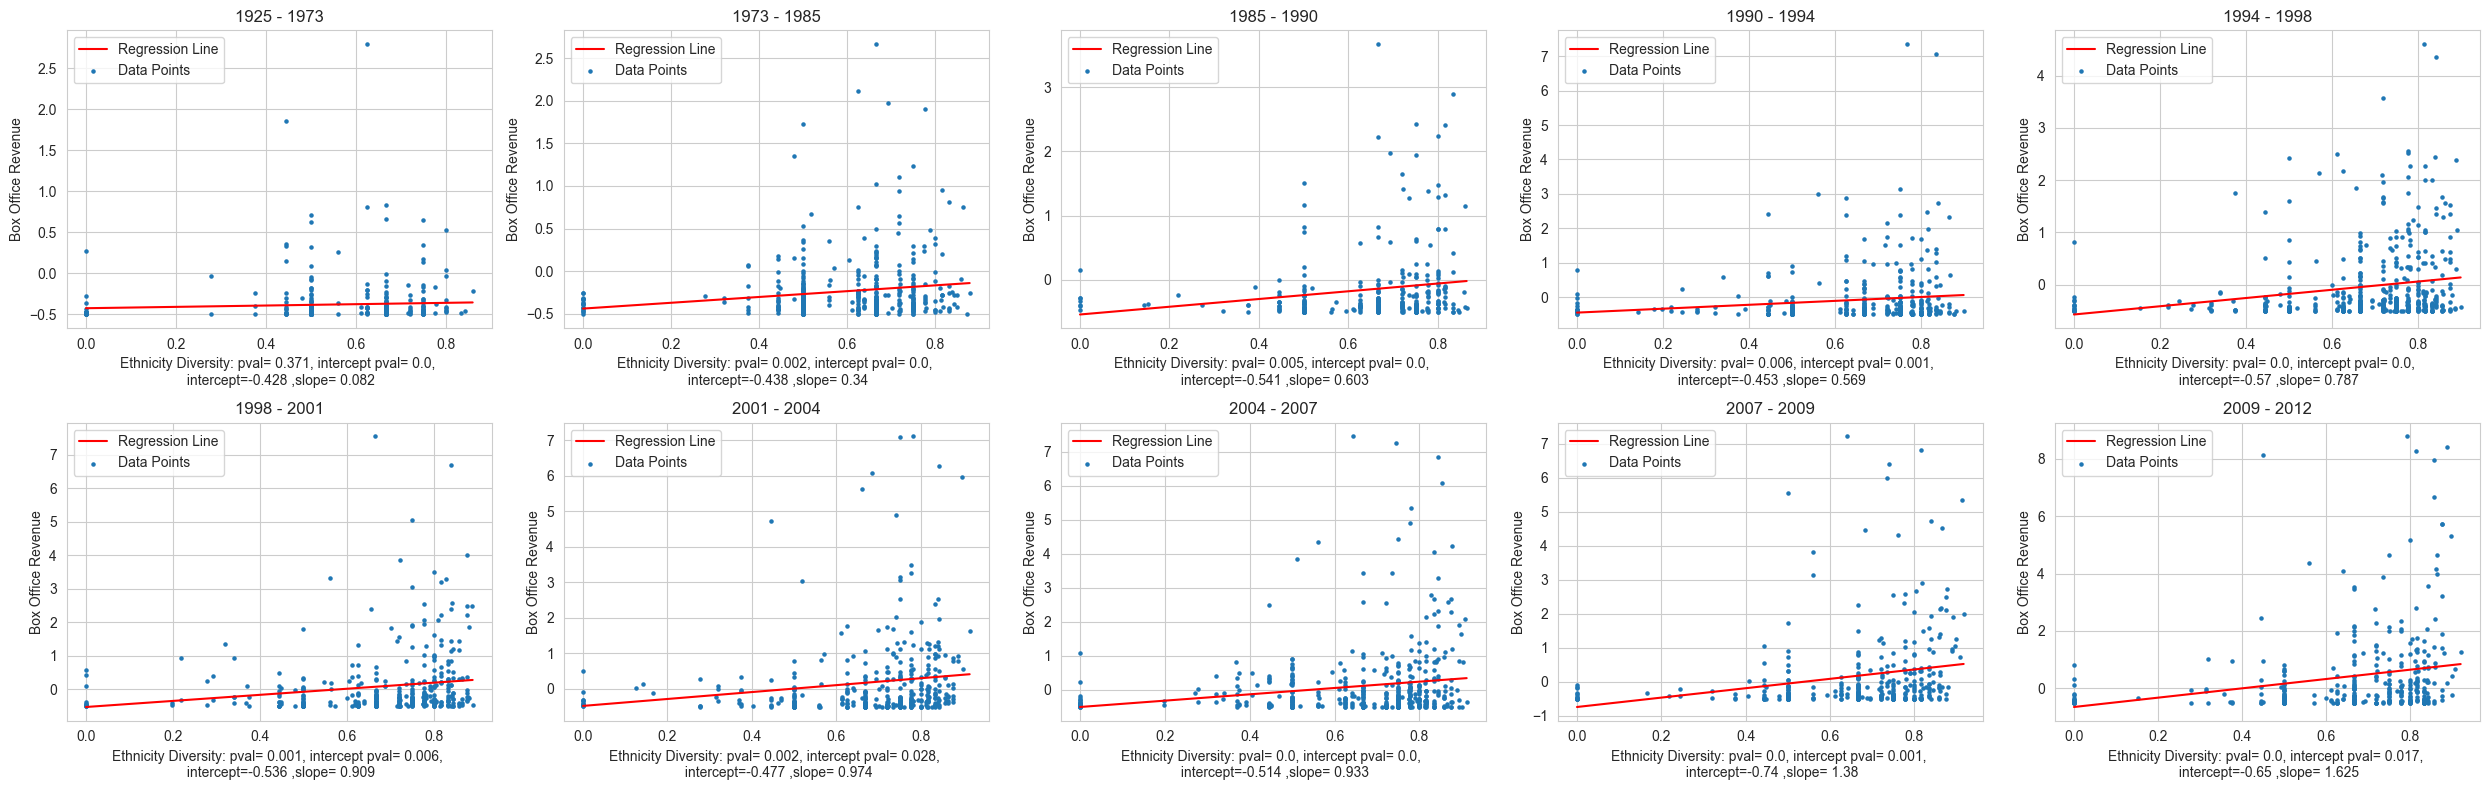

In [420]:
plot_regression_line(balanced_dfs,mods,cutoff,'ethnicity_diversity','movie_box_office_revenue')

We notice a statistically significative positive correlation (pvalue(Ethnicity Diversity) < 0.05) between the Ethnicity Diversity and the Box Office Revenue along the years except for the year range (1925-1973).   
One reason may explain this difference:
- The dataframe is missing many actors per movie for the ones released before the 70's 

Perhaps having a diviersified cast was not correlated with a better Box Office Revenue before the 70's however, from the 70's to nowadays it does has an impact. More the casting is Diversified in terms of ethnicity more the box office revenue will be high.  

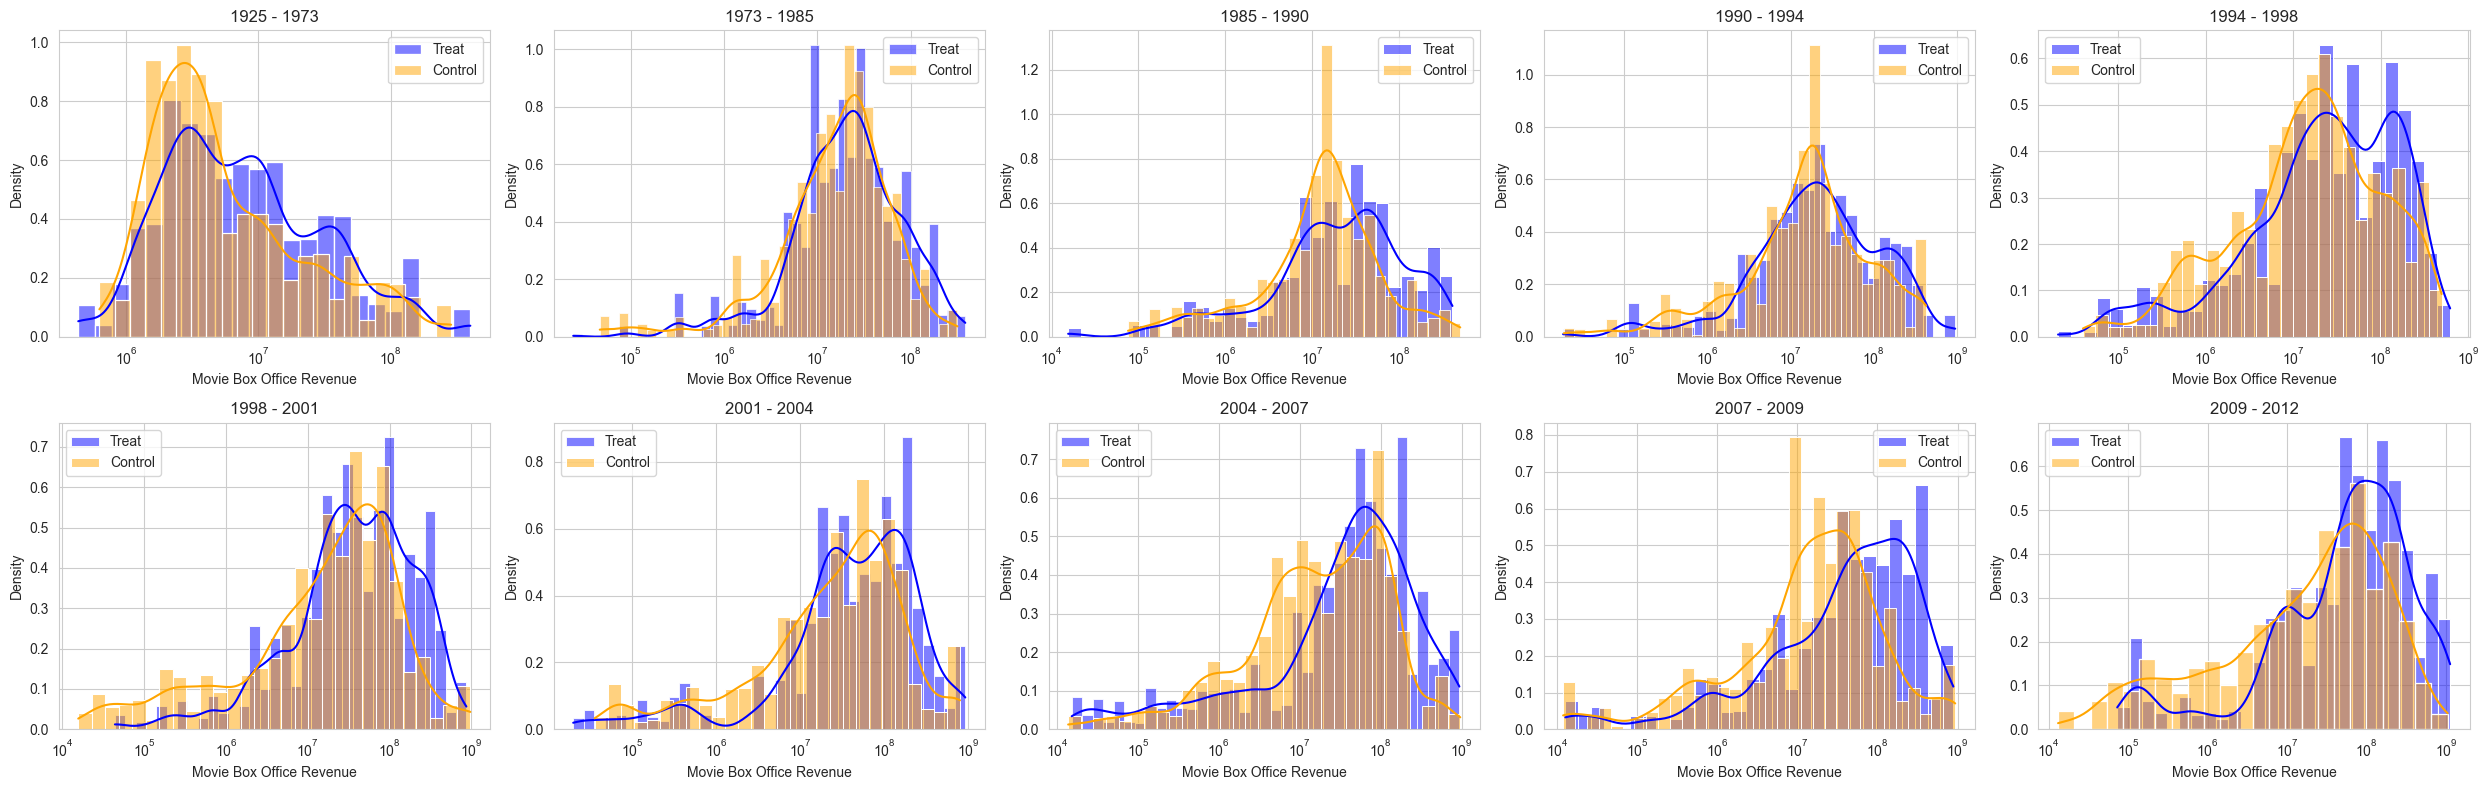

In [421]:
plot_comparison(balanced_dfs,cutoff,'Box_office')

This plot shows the distribution of the 2 groups (Control (Low Diversity) and Treatment (High Diversity)) of the Box Office Revenue. The movies are divided in 10 groups according to their year of release. It allows to figure out if there is a difference along the time. Overall the movie box office for the treated group is higher than the one of the control group except for the year range (1925-1973). Therefore according to both plots above, we can conclude that the treatment (High Diversity) has an impact on the box office revenue of a movie after the 70's.

 

### Gender vs Box office

In this section we will try to figure out if there is a correlation between the diversity of a cast (in terms of gender) and the box office revenue of a movie. The values in the columns `gender_diversity` is based on the number of different ethnicity in the cast of movie. It is computed with the simpson diversity.  
Then for each part we perfomed a causal analysis on the Movie Box Office Revenue by performing a propensity score matching on the `movie_languages_count` and on the `rating_average`. Finally we performed an Ordinary Least Squares (OLS) regression analysis on the balanced dataset. 

In [422]:
#Filter the dataframe according to the performance parameter
gen_div_filter = filtering(gen_div,'box_office')

#Split the dataframe in number_parts according to the year of release
period_df_gb ,cutoff_gb = year_release_split(gen_div_filter, number_parts=10)

#Perform the regression for each period
balanced_dfs_gb, mods_gb = compute_all_regressions(period_df=period_df_gb,
                        formula = 'movie_box_office_revenue ~ gender_diversity',
                        formula_propensity_score = 'gender_diversity ~ movie_languages_count + rating_average',
                        diversity_name = 'gender_diversity',
                        columns = ['movie_languages_count','rating_average'])

print('Size of the Dataframe before filtering :',gen_div.shape[0])
print('Size of the Dataframe after filtering :',gen_div_filter.shape[0])


Size of the Dataframe before filtering : 29887
Size of the Dataframe after filtering : 5600


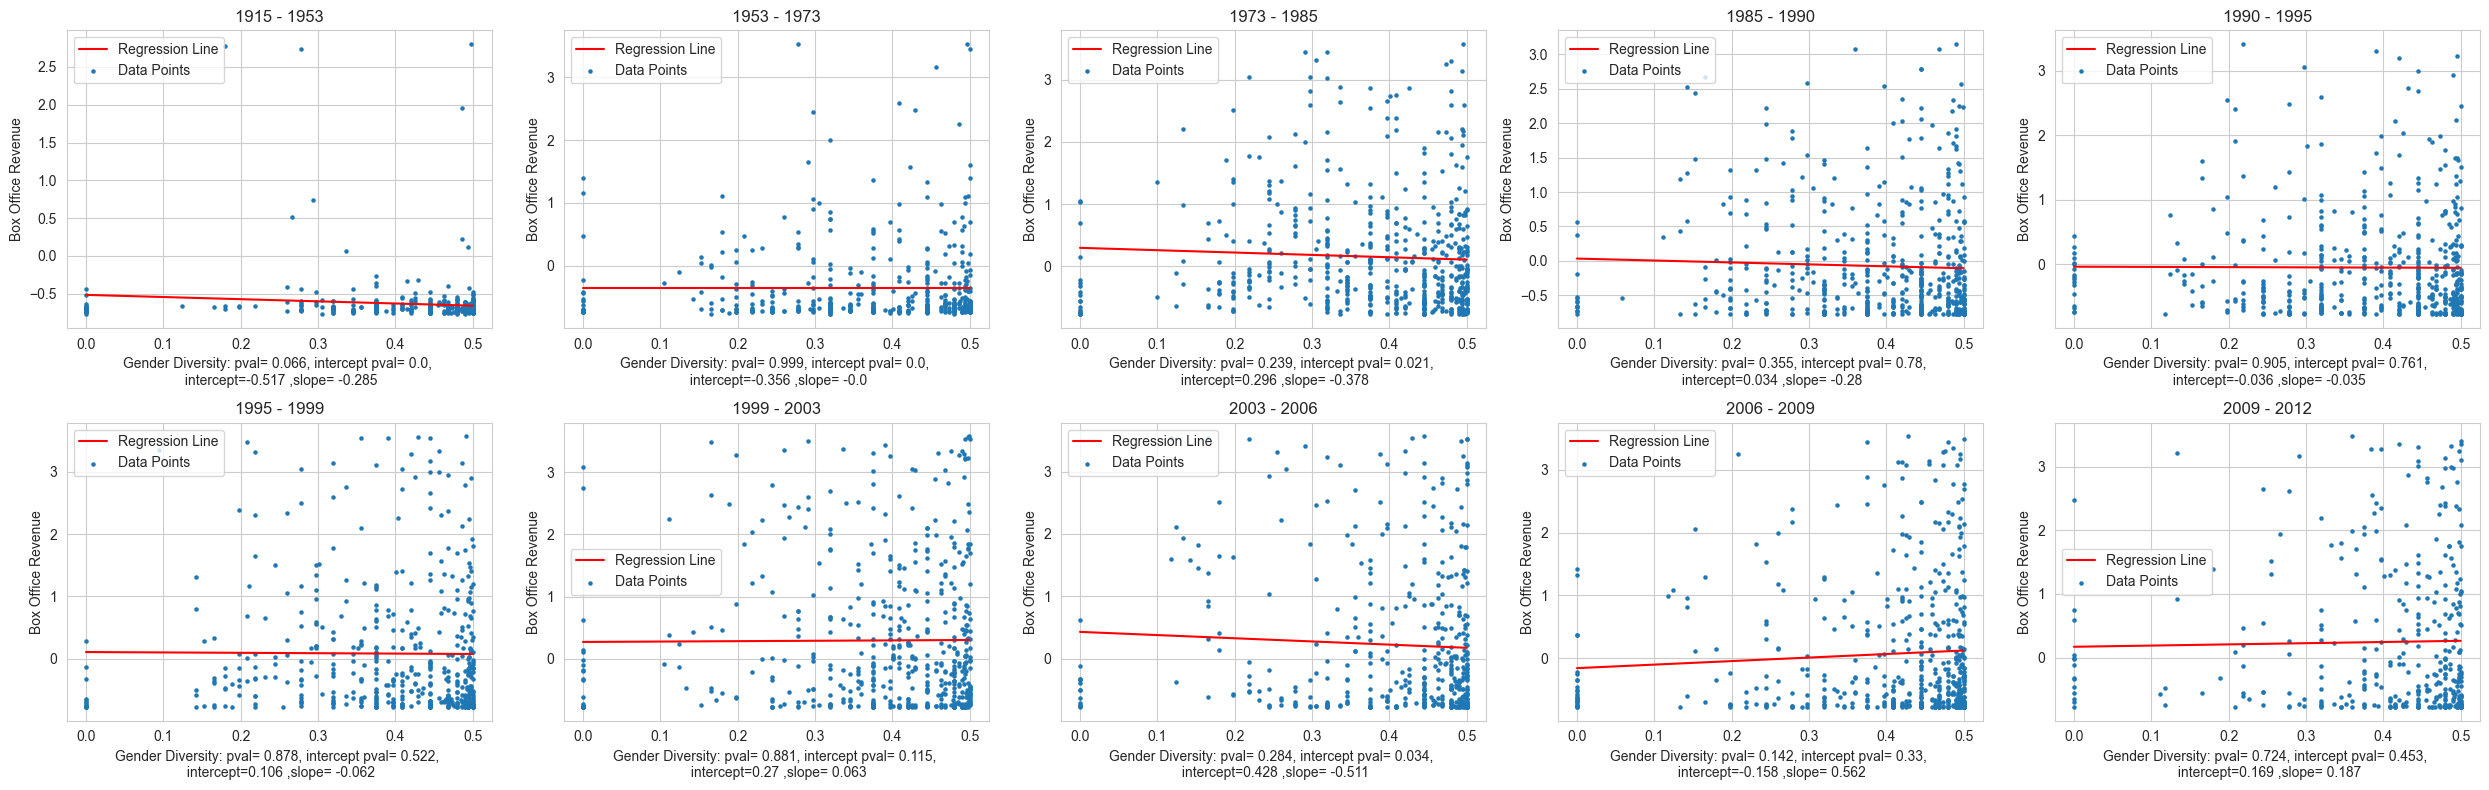

In [423]:
plot_regression_line(balanced_dfs_gb,mods_gb,cutoff_gb,'gender_diversity','movie_box_office_revenue', 'Gender Diversity')

On these plots above the regression line (in red) is very flat, furthermore the pvalue of the Gender Diversity is alaways above the 0.05 which means that we cannot reject the null hypothesis (there is no difference between the treated and the control group for the box office revenue). 

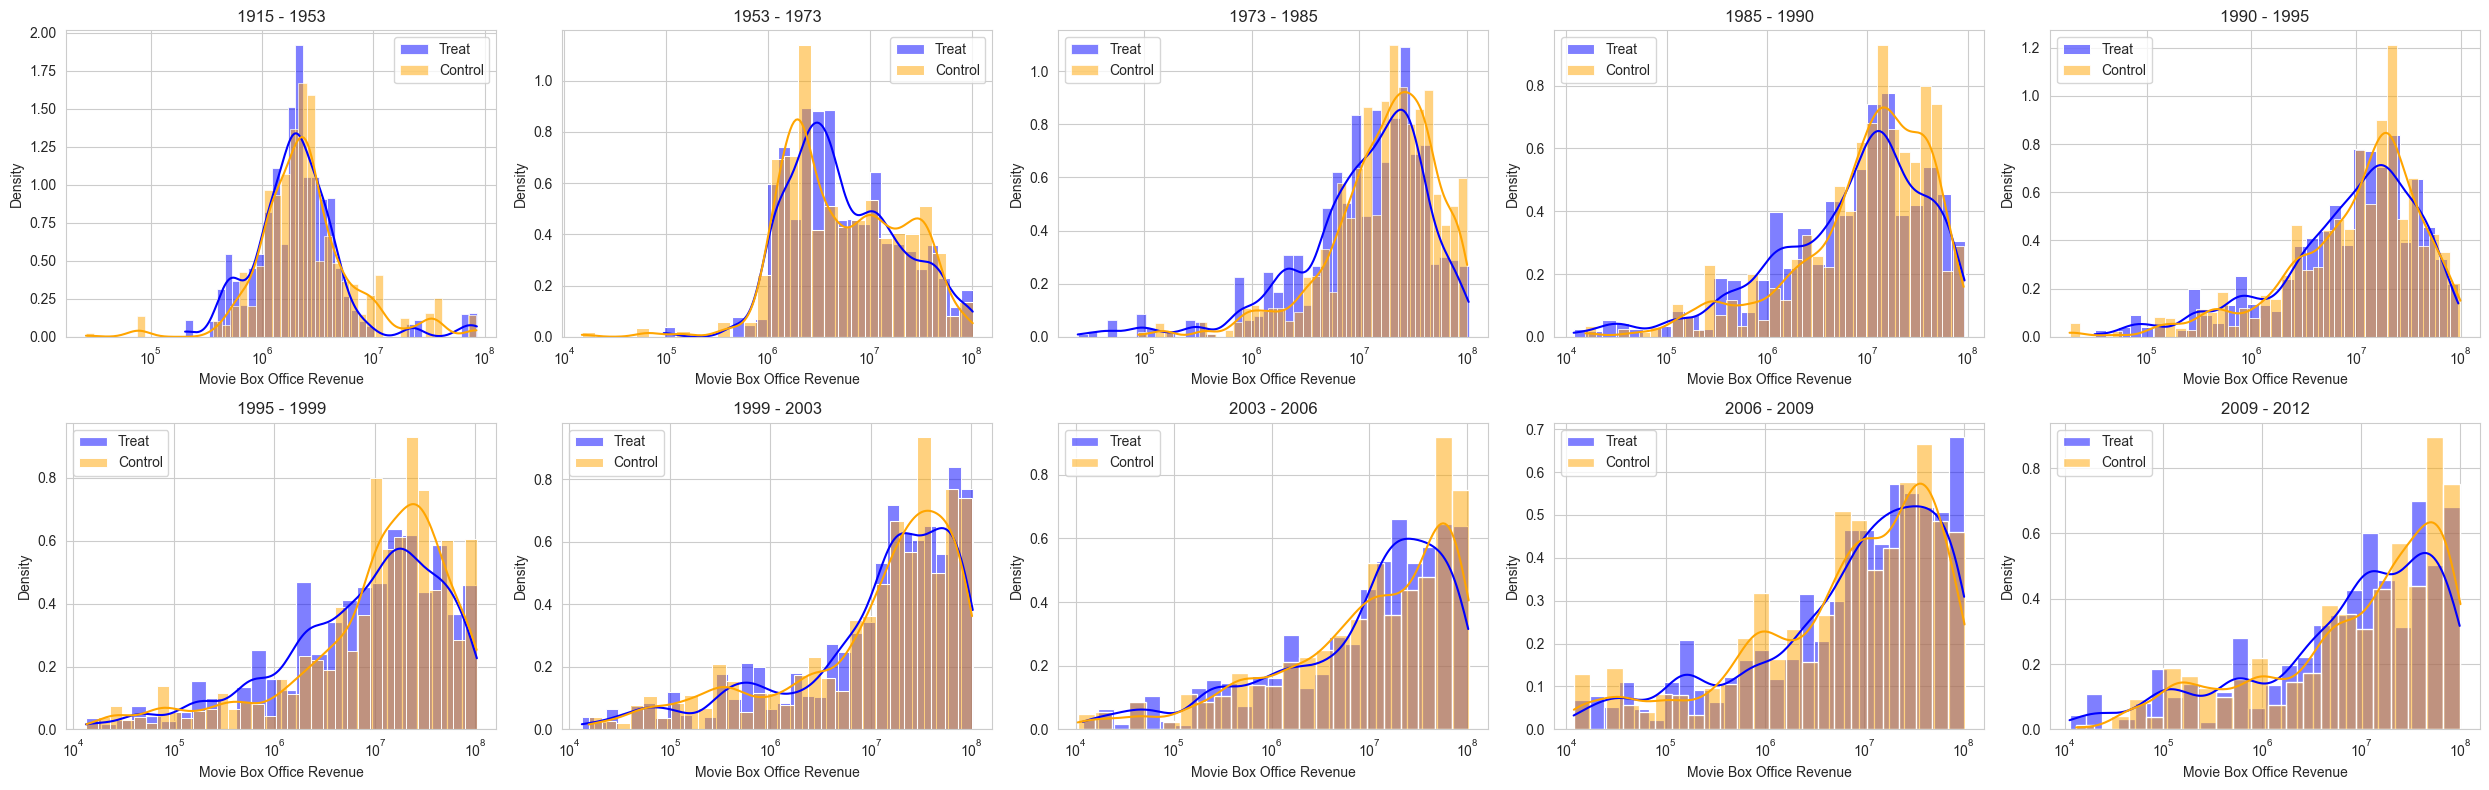

In [424]:
plot_comparison(balanced_dfs_gb,cutoff_gb,'Box_office')

This plot shows the distribution of the 2 groups (Control (Low Diversity) and Treatment (High Diversity)) of the Box Office Revenue. The movies are divided in 10 groups according to their year of release. It allows to figure out if there is a difference along the time. According to the plot there is no difference the 2 distributions overlap.  
We can conclude after the analyze of both plots that there is no correlation bewtween the diversity in a cast (in terms of gender) and the movie box office revenue.

### Ethnicity vs Ratings

In this section we will try to figure out if there is a correlation between the diversity of a cast (in terms of ethnicity) and the rating of a movie. The values in the columns `ethnicity_diversity` is based on the number of different ethnicity in the cast of movie. It is computed with the simpson diversity.  
Then, for each part we perfomed a causal analysis on the Rating by performing a propensity score matching on the `movie_languages_count` and on the `movie_box_office_revenue`. Finally, we performed an Ordinary Least Squares (OLS) regression analysis on the balanced dataset. 

In [425]:
#Filter the dataframe according to the performance parameter
ethn_div_filter_r = filtering(ethn_div,'rating')

#Split the dataframe in number_parts according to the year of release
period_df_er ,cutoff_er = year_release_split(ethn_div_filter_r, number_parts=10)

#Perform the regression for each period
balanced_dfs_er, mods_er = compute_all_regressions(period_df=period_df_er,
                        formula = 'rating_average ~ ethnicity_diversity',
                        formula_propensity_score = 'ethnicity_diversity ~ movie_languages_count + movie_box_office_revenue',
                        diversity_name = 'ethnicity_diversity',
                        columns = ['movie_languages_count','rating_average'])

print('Size of the Dataframe before Filtering :',ethn_div.shape[0])
print('Size of the Dataframe after Filtering :',ethn_div_filter_r.shape[0])


Size of the Dataframe before Filtering : 12640
Size of the Dataframe after Filtering : 3534


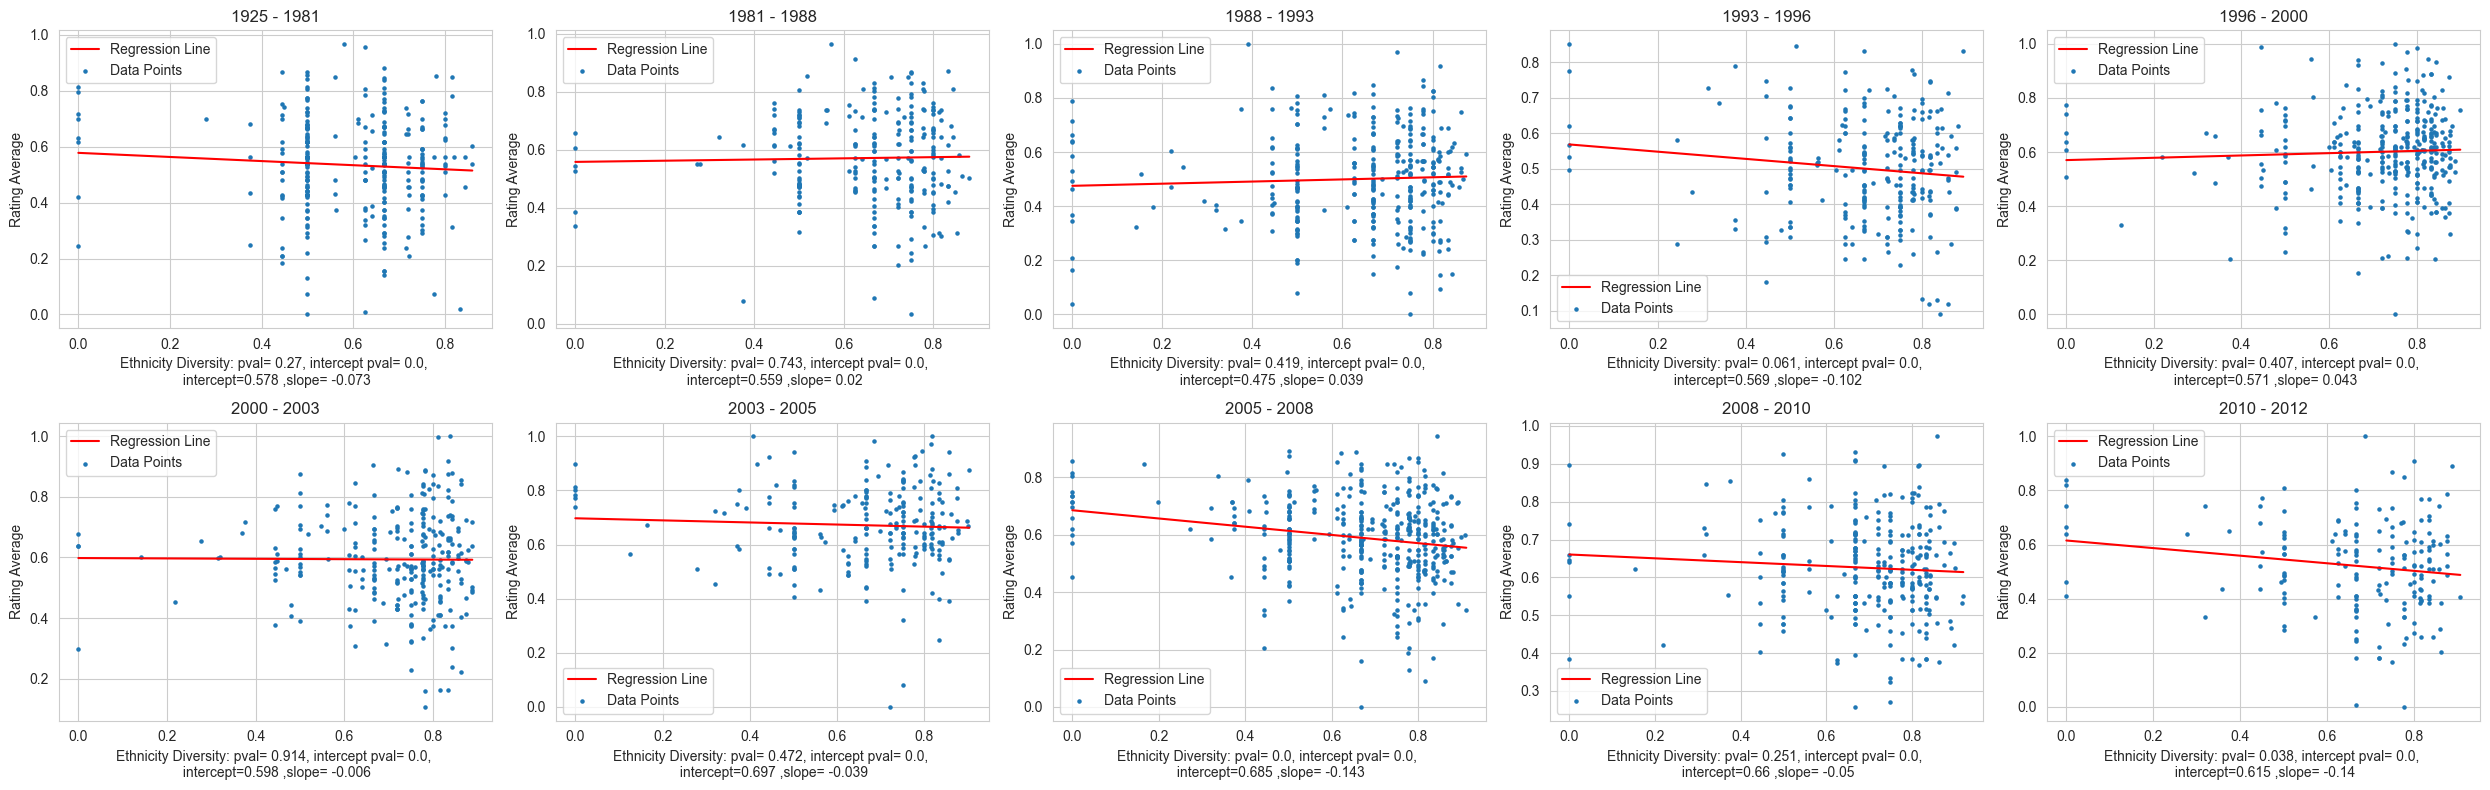

In [426]:
plot_regression_line(balanced_dfs_er,mods_er, cutoff_er,'ethnicity_diversity', 'rating_average', 'Ethnicity Diversity', 'Rating Average')


On these plots above the regression line (in red) is very flat or slightly goes down, furthermore on most of them, the pvalue of the Ethnicity Diversity is alaways above the 0.05 which means that we cannot reject the null hypothesis (there is no difference between the treated and the control group for the box office revenue). For the movies released between 2005 and 2008 the pvalue is below 0.05 and the slope is negative which can be translated by a statistically significant negative correlation between the ethnicity diversity and the rating of a movie.

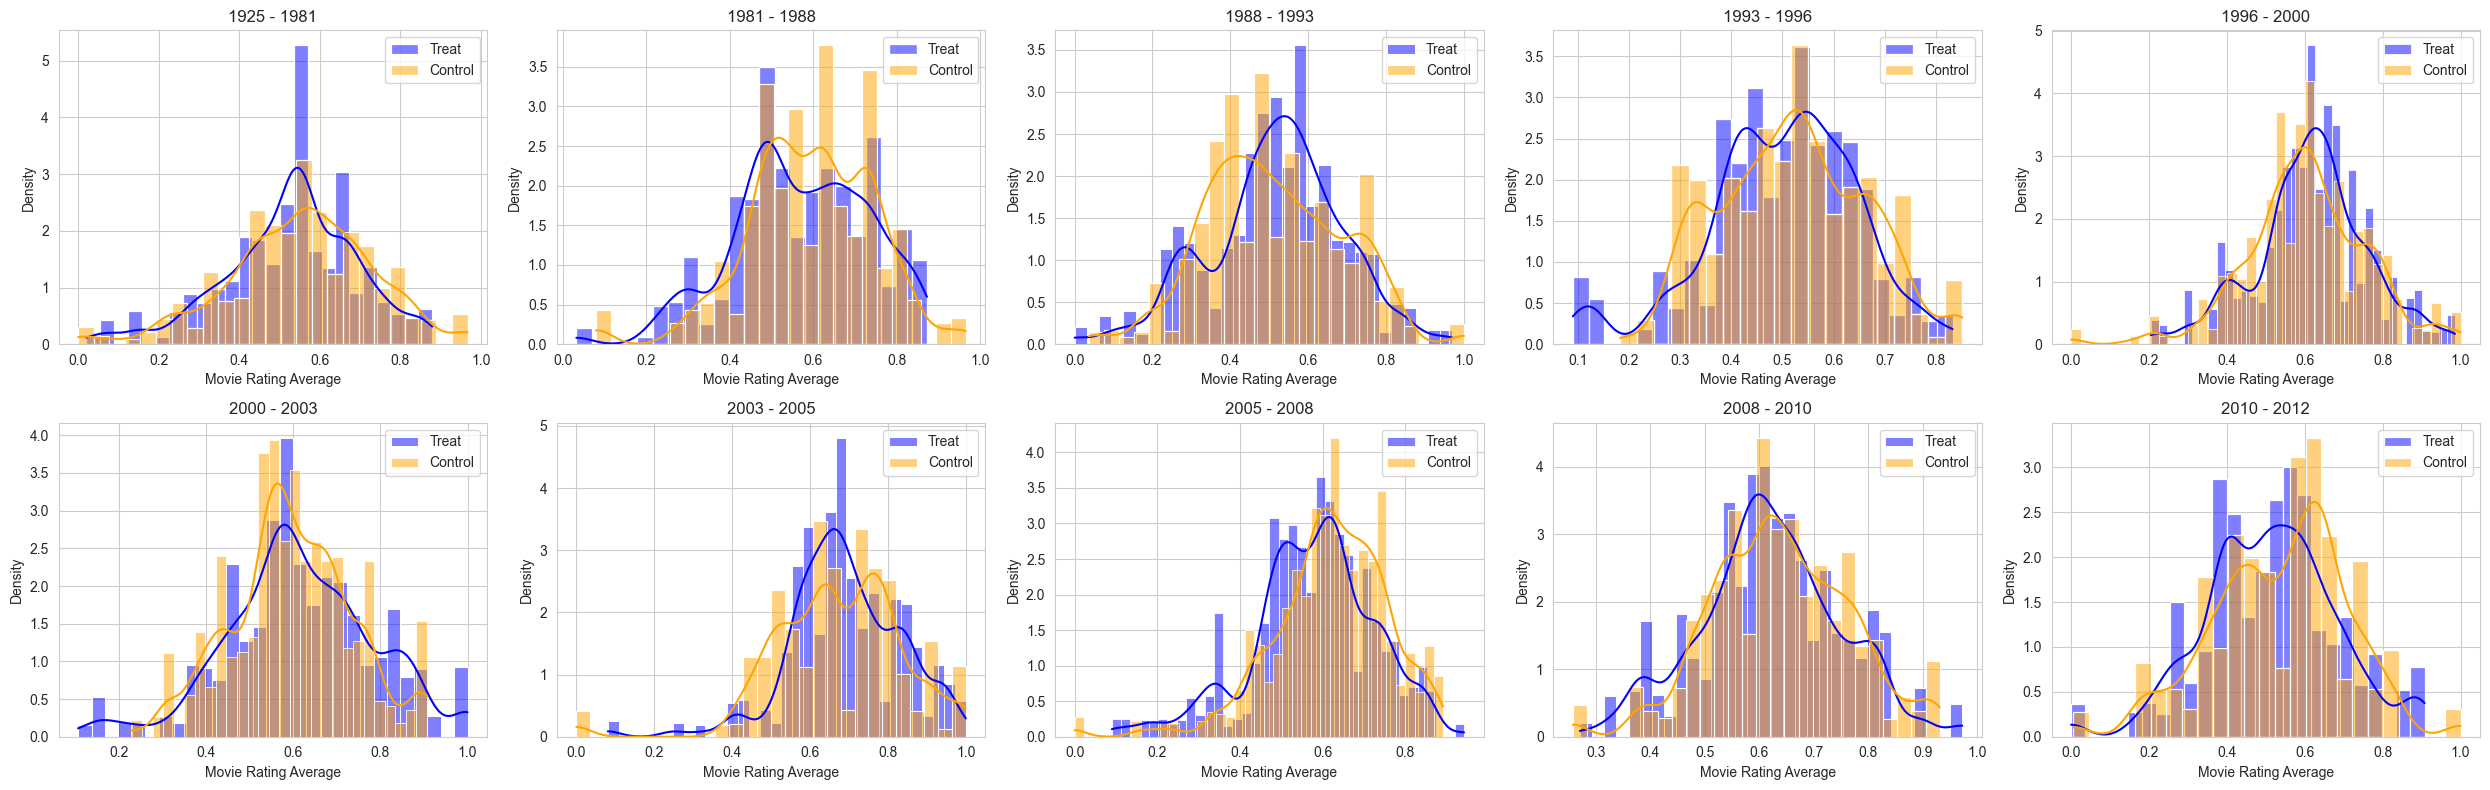

In [427]:
plot_comparison(balanced_dfs_er,cutoff_er,'rating_average')

This plot shows the distribution of the 2 groups (Control (Low Diversity) and Treatment (High Diversity)) of the Rating of a movie. The movies are divided in 10 groups according to their year of release. It allows to figure out if there is a difference along the time. According to the plot there is almost no difference the 2 distributions overlap most of time. Sometimes the treatment is even more on the left which means that the the movies with the lowest diversity get a better rating.  
It is hard to conclude based on the analysis of both plots but we can affirm at least there is no positive correlation between the diversity in terms of ethnictiy and the rating of a movie. As in most of the year range there is no correlation between the diversity and the rating it might be the case on the entire period. To obtain more precision read the causal analysis on the entire period.

### Gender vs Ratings

In this section we will try to figure out if there is a correlation between the diversity of a cast (in terms of gender) and the rating of a movie. The values in the columns `gender_diversity` is based on the number of different ethnicity in the cast of movie. It is computed with the simpson diversity.  
Then, for each part we perfomed a causal analysis on the Rating by performing a propensity score matching on the `movie_languages_count` and on the `movie_box_office_revenue`. Finally, we performed an Ordinary Least Squares (OLS) regression analysis on the balanced dataset. 

In [428]:
#Filter the dataframe according to the performance parameter
gen_div_filter_r = filtering(gen_div,'rating')

#Split the dataframe in number_parts according to the year of release
period_df_gr ,cutoff_gr = year_release_split(gen_div_filter_r, number_parts=10)

#Perform the regression for each period
balanced_dfs_gr, mods_gr = compute_all_regressions(period_df=period_df_gr,
                        formula = 'rating_average ~ gender_diversity',
                        formula_propensity_score = 'gender_diversity ~ movie_languages_count + movie_box_office_revenue',
                        diversity_name = 'gender_diversity',
                        columns = ['movie_languages_count','rating_average'])

print('Size of the Dataframe before filtering :',gen_div.shape[0])
print('Size of the Dataframe after filtering :',gen_div_filter_r.shape[0])

Size of the Dataframe before filtering : 29887
Size of the Dataframe after filtering : 3406


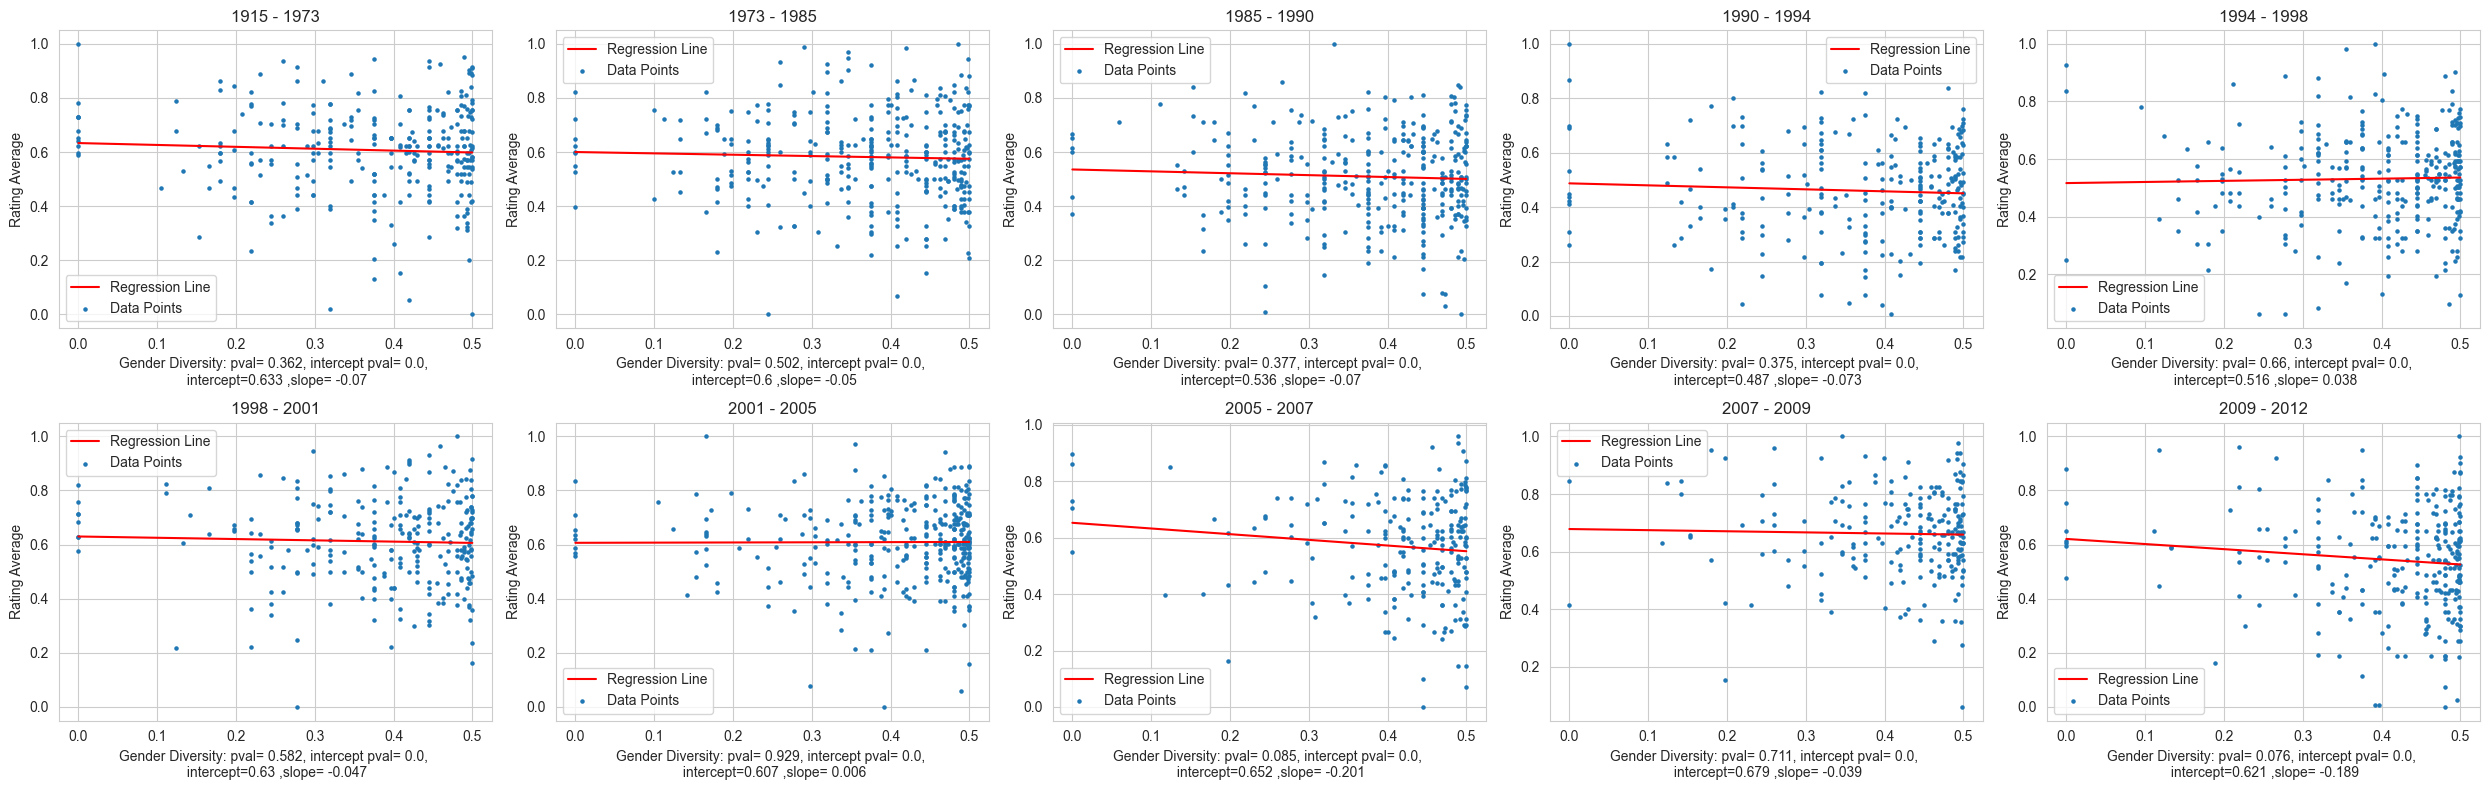

In [429]:
plot_regression_line(balanced_dfs_gr,mods_gr, cutoff_gr,'gender_diversity', 'rating_average', 'Gender Diversity', 'Rating Average')


On these plots above the regression line (in red) is very flat or slightly goes down, furthermore the pvalue of the Ethnicity Diversity is alaways above the 0.05 which means that we cannot reject the null hypothesis (there is no difference between the treated (movies with a high diversity) and the control (movies with a low diversity) group for the box office revenue). 

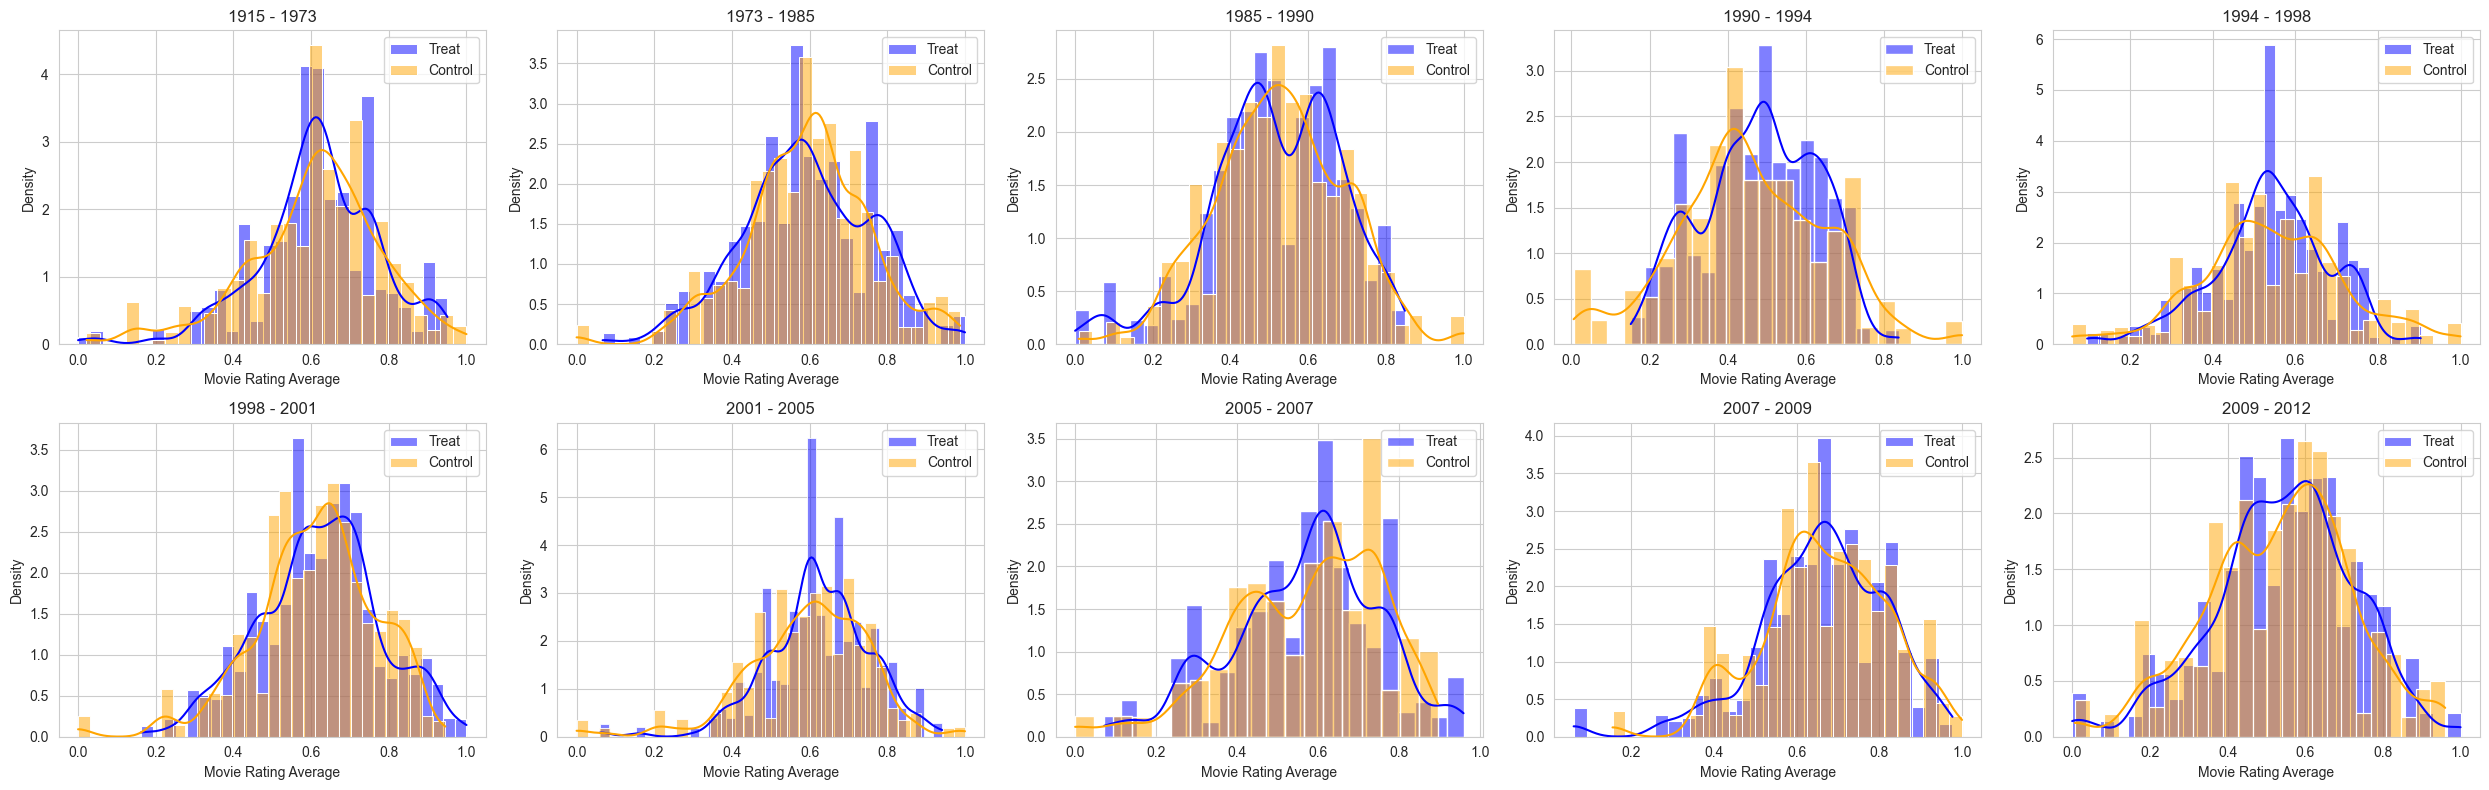

In [430]:
plot_comparison(balanced_dfs_gr,cutoff_gr,'rating_average')

This plot shows the distribution of the 2 groups (Control (Low Diversity) and Treatment (High Diversity)) of the Rating of a movie. The movies are divided in 10 groups according to their year of release. It allows to figure out if there is a difference along the time. According to the plot there is  no difference, the 2 distributions overlap most of time.
Based on the analysis of both plots but we can affirm at least there is no positive correlation between the diversity in terms of ethnictiy and the rating of a movie. As in most of the year range there is no correlation between the diversity and the rating it might be the case on the entire period. To obtain more precision read the causal analysis on the entire period.